## Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

In [ ]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

# Laboratoire 4: Régularisation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import poutyne as pt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from deeplib.datasets import load_cifar10, load_mnist, train_valid_loaders
from deeplib.net import CifarNet, CifarNetBatchNorm
from deeplib.training import train, test

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

cifar_train, cifar_test = load_cifar10()
mnist_train, mnist_test = load_mnist()

Files already downloaded and verified
Files already downloaded and verified


## 1. Régularisation L1 et L2

### Implémentation manuelle
La régularisation L2 est communément appelée **weight decay**. Dans PyTorch, les optimiseurs de `torch.optim` ont un paramètre `weight_decay` pour utiliser cette régularisation. Par contre, on peut facilement implémenter manuellement la régularisation L2 comme une pénalité sur la norme des poids (voir le [chapitre 7.1](http://www.deeplearningbook.org/contents/regularization.html)).

#### Exercice
Complétez la fonction *loss_init* en ajoutant manuellement la pénalité sur les paramètres du réseau selon une régularisation L1 ou L2. Le paramètre *reg_alpha* correspond à l'hyperparamètre de régularisation $\alpha$ du livre ($\lambda$ dans les acétates du cours). Le paramètre *p* correspond à l'ordre de la norme: $p=1$ pour la norme L1 et $p=2$ pour la norme L2.

In [2]:
def loss_init(parameters=[], reg_alpha=0, p=2):
    cross_entropy = nn.CrossEntropyLoss()
    
    def loss_function(output, targets):
        loss = cross_entropy(output,targets)
        
        for param in parameters:
            # TODO
            loss += reg_alpha/p * torch.norm(param, p=p) ** p
        
        return loss
    return loss_function

Testez votre implémentation de la régularisation par la norme L2 ($p=2$):

In [3]:
torch.manual_seed(42)
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=0.1)
loss = loss_init(net.parameters(), reg_alpha=1e-3, p=2)

history = train(net, optimizer, cifar_train, n_epoch=5, batch_size=64, use_gpu=True, criterion=loss)

Epoch: 1/5 Step: 625/625 100.00% |█████████████████████████|7.07s loss: 1.895754 acc: 31.240000 val_loss: 1.540520 val_acc: 44.940000
Epoch: 2/5 Step: 625/625 100.00% |█████████████████████████|6.73s loss: 1.406740 acc: 49.552500 val_loss: 1.279533 val_acc: 54.690000
Epoch: 3/5 Step: 625/625 100.00% |█████████████████████████|6.89s loss: 1.196780 acc: 57.820000 val_loss: 1.165596 val_acc: 58.730000
Epoch: 4/5 Step: 625/625 100.00% |█████████████████████████|6.66s loss: 1.033463 acc: 64.050000 val_loss: 1.034677 val_acc: 63.990000
Epoch: 5/5 Step: 625/625 100.00% |█████████████████████████|7.46s loss: 0.912657 acc: 68.432500 val_loss: 0.959110 val_acc: 67.290000


Testez votre implémentation de la régularisation par la norme L1 ($p=1$):

In [4]:
torch.manual_seed(42)
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=0.1)
loss = loss_init(net.parameters(), reg_alpha=1e-3, p=1)

history = train(net, optimizer, cifar_train, n_epoch=5, batch_size=64, use_gpu=True, criterion=loss)

Epoch: 1/5 Step: 625/625 100.00% |█████████████████████████|6.93s loss: 1.904640 acc: 31.115000 val_loss: 1.540845 val_acc: 45.070000
Epoch: 2/5 Step: 625/625 100.00% |█████████████████████████|7.05s loss: 1.406768 acc: 49.512500 val_loss: 1.275809 val_acc: 54.800000
Epoch: 3/5 Step: 625/625 100.00% |█████████████████████████|7.32s loss: 1.195006 acc: 57.890000 val_loss: 1.163257 val_acc: 59.130000
Epoch: 4/5 Step: 625/625 100.00% |█████████████████████████|7.04s loss: 1.032895 acc: 64.037500 val_loss: 1.053562 val_acc: 63.200000
Epoch: 5/5 Step: 625/625 100.00% |█████████████████████████|6.81s loss: 0.913044 acc: 68.325000 val_loss: 0.964672 val_acc: 66.680000


### Utilisation du *weight decay*

Explorons maintenant l'utilisation du paramètre `weight_decay` disponible dans les optimiseurs de `PyTorch` pour effectuer de la régularisation L2. Nous allons entrainez un réseau de neurones avec régularisation L2 et un autre sans pour pouvoir observer l'impact de la régularisation sur l'apprentissage et le réseau appris.

In [5]:
# Paramètres
batch_size = 64
lr = 0.1
n_epoch = 15

Réseau sans régularisation L2:

Epoch: 1/15 Step: 625/625 100.00% |█████████████████████████|6.99s loss: 1.903057 acc: 31.150000 val_loss: 1.530082 val_acc: 45.570000
Epoch: 2/15 Step: 625/625 100.00% |█████████████████████████|6.45s loss: 1.407716 acc: 49.447500 val_loss: 1.277584 val_acc: 54.910000
Epoch: 3/15 Step: 625/625 100.00% |█████████████████████████|6.53s loss: 1.194868 acc: 57.940000 val_loss: 1.162652 val_acc: 58.980000
Epoch: 4/15 Step: 625/625 100.00% |█████████████████████████|7.31s loss: 1.033289 acc: 64.062500 val_loss: 1.050791 val_acc: 63.500000
Epoch: 5/15 Step: 625/625 100.00% |█████████████████████████|7.35s loss: 0.914597 acc: 68.242500 val_loss: 0.956439 val_acc: 67.030000
Epoch: 6/15 Step: 625/625 100.00% |█████████████████████████|6.61s loss: 0.808907 acc: 71.900000 val_loss: 0.972145 val_acc: 66.240000
Epoch: 7/15 Step: 625/625 100.00% |█████████████████████████|7.17s loss: 0.720694 acc: 75.142500 val_loss: 0.924519 val_acc: 68.440000
Epoch: 8/15 Step: 625/625 100.00% |████████████████████

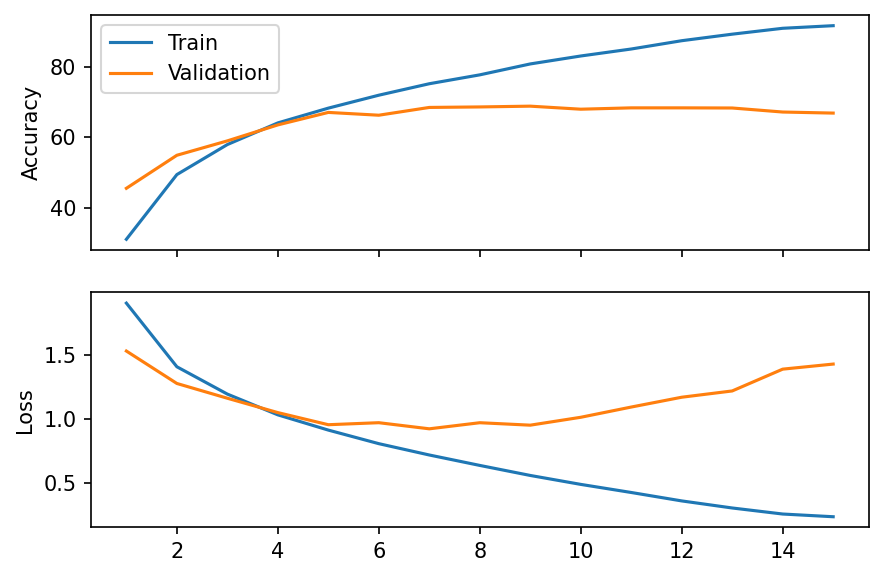

Précision en test: 67.52


In [6]:
torch.manual_seed(42)
net_without_l2 = CifarNet()
optimizer_without_l2 = optim.SGD(net_without_l2.parameters(), lr=lr, weight_decay=0)

history_without_l2 = train(net_without_l2, optimizer_without_l2, cifar_train, n_epoch, batch_size, use_gpu=True)
history_without_l2.display()
print('Précision en test: {:.2f}'.format(test(net_without_l2, cifar_test, batch_size)))

Réseau avec régularisation L2 (*weight decay*):

Epoch: 1/15 Step: 625/625 100.00% |█████████████████████████|6.94s loss: 1.909484 acc: 31.015000 val_loss: 1.536306 val_acc: 45.680000
Epoch: 2/15 Step: 625/625 100.00% |█████████████████████████|6.71s loss: 1.425565 acc: 48.887500 val_loss: 1.292932 val_acc: 54.490000
Epoch: 3/15 Step: 625/625 100.00% |█████████████████████████|6.76s loss: 1.223812 acc: 56.932500 val_loss: 1.171038 val_acc: 58.900000
Epoch: 4/15 Step: 625/625 100.00% |█████████████████████████|7.08s loss: 1.068503 acc: 62.892500 val_loss: 1.072303 val_acc: 62.650000
Epoch: 5/15 Step: 625/625 100.00% |█████████████████████████|6.88s loss: 0.957633 acc: 66.700000 val_loss: 0.971748 val_acc: 66.750000
Epoch: 6/15 Step: 625/625 100.00% |█████████████████████████|6.64s loss: 0.861126 acc: 70.300000 val_loss: 0.962760 val_acc: 66.510000
Epoch: 7/15 Step: 625/625 100.00% |█████████████████████████|6.64s loss: 0.783724 acc: 72.877500 val_loss: 0.930019 val_acc: 68.150000
Epoch: 8/15 Step: 625/625 100.00% |████████████████████

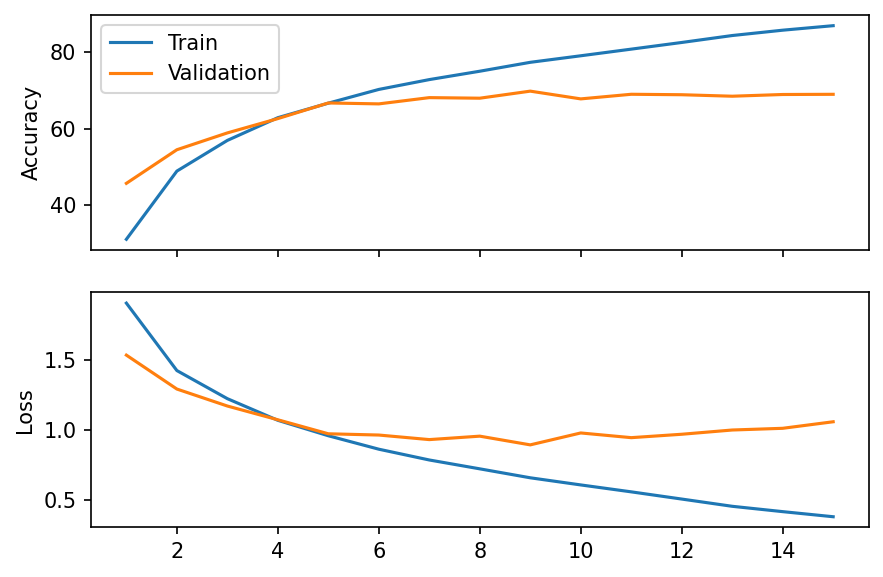

Précision en test: 69.34


In [7]:
weight_decay = 1e-3

torch.manual_seed(42)
net_l2 = CifarNet()
optimizer_l2 = optim.SGD(net_l2.parameters(), lr=lr, weight_decay=weight_decay)

history_l2 = train(net_l2, optimizer_l2, cifar_train, n_epoch, batch_size, use_gpu=True)
history_l2.display()
print('Précision en test: {:.2f}'.format(test(net_l2, cifar_test, batch_size)))

#### Questions
- Quel est l'effet de la régularisation L2 sur l'entraînement du réseau? **Au niveau de l'accuracy, on remarque que les performances en validation et en test sont légèrement meilleures. Également, l'utilisation de la régularisation réduit le surapprentissage. En effet l'écart des valeurs d'accuracy et de loss entre l'entraînement et la validation est nettement moins important (voir graphiques)**
- Si vous utilisez un weight_decay trop grand (exemple 0.1) qu'arrive-t-il? Pourquoi? **Le réseau ne parvient tout simplement pas à apprendre, car la pénalité sur les poids est trop importante.**

Dans la cellule suivante, analysez avec un histogramme la distribution des poids appris par les réseaux avec ou sans régularisation. 

- Que remarquez-vous? **Avec la régularisation L2, les poids appris sont plus concentrés près de 0.**

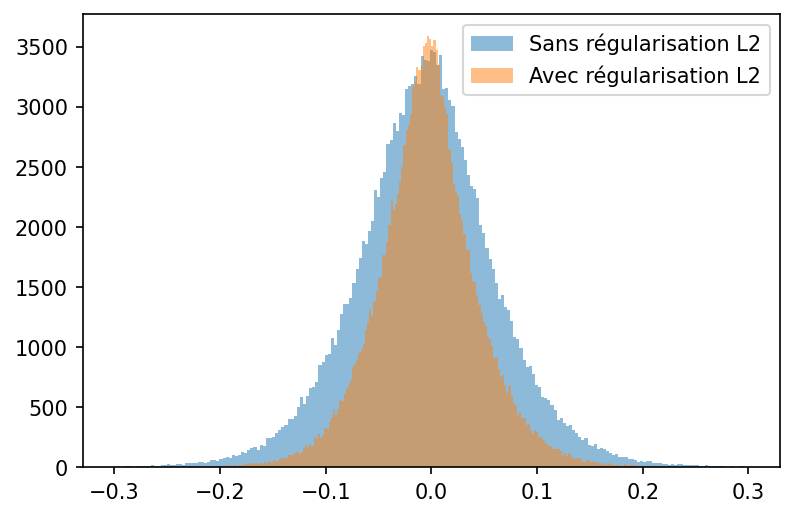

In [8]:
def net_to_weight_array(net):
    weights = []
    for p in net.parameters():
        p_numpy = p.data.cpu().numpy()
        weights.append(p_numpy.reshape((-1))) # Reshape to 1D array
    return np.concatenate(weights)

weights_without_l2 = net_to_weight_array(net_without_l2)
weights_l2 = net_to_weight_array(net_l2)

# Visualisation
plt.hist(weights_without_l2, bins='auto', range=(-0.3, 0.3), alpha =0.5, label="Sans régularisation L2")
plt.hist(weights_l2, bins='auto', range=(-0.3, 0.3), alpha=0.5, label="Avec régularisation L2")
plt.legend()
plt.show()

## 2. Early stopping

Commencez par entraîner un réseau pour un grand nombre d'époques. L'historique d'entraînement nous servira de base pour les questions qui suivent.

In [9]:
torch.manual_seed(42)
net = CifarNetBatchNorm()

optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-3, nesterov=True, momentum=0.9)
scheduler = pt.ReduceLROnPlateau(monitor='val_acc', mode='max', patience=3, factor=0.5, verbose=True)

history = train(net, optimizer, cifar_train, n_epoch=40, batch_size=64, callbacks=[scheduler], use_gpu=True)

Epoch: 1/40 Step: 625/625 100.00% |█████████████████████████|7.76s loss: 1.586654 acc: 45.552500 val_loss: 1.317513 val_acc: 52.300000
Epoch: 2/40 Step: 625/625 100.00% |█████████████████████████|7.68s loss: 1.180580 acc: 57.992500 val_loss: 1.182229 val_acc: 58.370000
Epoch: 3/40 Step: 625/625 100.00% |█████████████████████████|7.70s loss: 1.001798 acc: 64.782500 val_loss: 1.153590 val_acc: 59.450000
Epoch: 4/40 Step: 625/625 100.00% |█████████████████████████|7.59s loss: 0.874237 acc: 69.692500 val_loss: 1.033686 val_acc: 63.760000
Epoch: 5/40 Step: 625/625 100.00% |█████████████████████████|7.94s loss: 0.785897 acc: 73.055000 val_loss: 1.007952 val_acc: 65.630000
Epoch: 6/40 Step: 625/625 100.00% |█████████████████████████|8.10s loss: 0.714726 acc: 75.215000 val_loss: 0.941897 val_acc: 67.430000
Epoch: 7/40 Step: 625/625 100.00% |█████████████████████████|7.44s loss: 0.651940 acc: 77.590000 val_loss: 0.938787 val_acc: 67.940000
Epoch: 8/40 Step: 625/625 100.00% |████████████████████

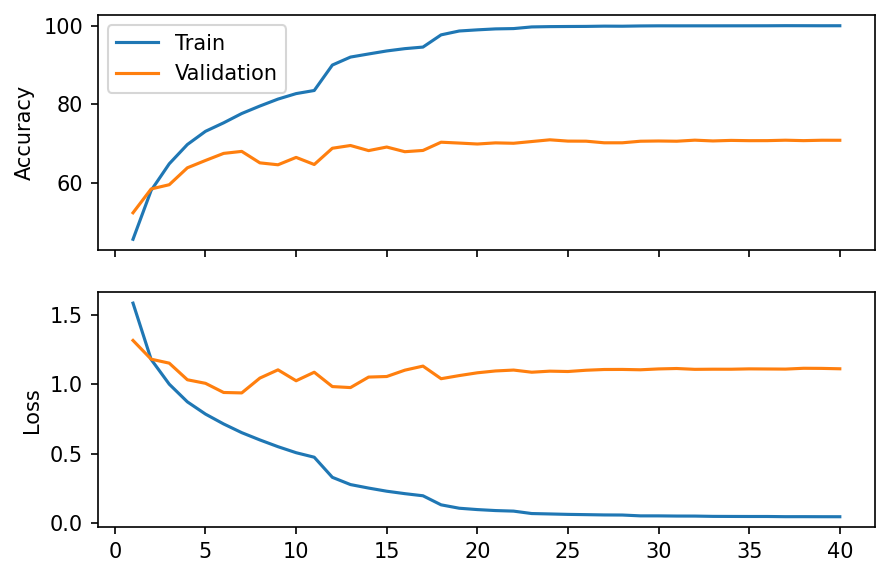

In [10]:
history.display()

#### Question
- En regardant les graphiques ci-dessus, quel est le meilleur moment pour arrêter l'entraînement? **Autour de l'époque 20 la précision en validation semble la plus élevée et commence à être stable.**

L'algorithme 7.1 du livre (voir http://www.deeplearningbook.org/contents/regularization.html page 244) décrit le paramètre de patience `p` dans le contexte d'un algorithme de *early stopping*.

#### Exercice
Analysez l'effet du choix de `p` sur les données de l'entraînement précédent. Regardez pour `p = 1,2,5,10,15`, quelle époque avec quelle précision en validation est choisie. Implémentez un algorithme effectuant du *early stopping* en utilisant l'historique `val_accuracy` de l'entraînement que vous venez d'exécuter pour vos tests (à la place d'entraîner le réseau).

In [12]:
# Historique
val_accuracy_history = history.history['val_acc']

# Patience
p = 5

best_val_accuracy = -np.inf
best_epoch = -1

# TODO
counter = 0
for epoch, val_accuracy in enumerate(val_accuracy_history):
    # Amélioration de la précision en validation
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        counter = 0
    # On patiente ...
    else:
        counter += 1
        if counter == p:
            break
# TODO END
            
print("Pour patience p={}, la meilleure époque est {}, avec précision en validation de {:.2f}.".format(p, best_epoch, best_val_accuracy))

Pour patience p=5, la meilleure époque est 23, avec précision en validation de 70.89.


#### Question

- Identifiez des problèmes pratiques potentiels lors de l'utilisation du *early stopping*. **Il est difficile de sélectionner la bonne valeur de patience. Une valeur trop faible arrête l'entraînement trop tôt ce qui peut résulter en un modèle avec de moins bonnes performances, alors qu'une valeur trop élevée de patience peut nous obliger à calculer un nombre d'époques plus important que nécessaire (temps)**

## 3. Dropout
Cette section a pour but d'analyser l'effet du dropout dans un réseau fully connected. Nous ferons cette analyse en reprenant l'exercice du laboratoire 2.


#### Exercice
Dans le réseau suivant, implémentez la fonction `forward()` formée de couches linéaires suivies d'activation   `Relu` en ajoutant du dropout ([Indice](https://pytorch.org/docs/stable/nn.functional.html?highlight=dropout#torch.nn.functional.dropout)) après l'activation si `self.use_dropout == True` . Utilisez une probabilité de dropout de `0.3` indiqué par `self.dropout_p` et ne faites pas de dropout sur la couche de sortie. N'ajoutez **pas de softmax** car la fonction `deeplib.training.train()` utilise par défaut `CrossEntropyLoss`, ce qui le fait pour vous. 

> **ATTENTION!** Vous devez bien fixer l'argument `training` de dropout. Vous pouvez savoir si modèle est en entraînement ou en évaluation avec `self.training`.

In [13]:
class MnistModel(torch.nn.Module):
    
    def __init__(self, n_layers, hidden_size=100, use_dropout=True, dropout_p=0.3):
        super().__init__()
        torch.manual_seed(42)
        self.use_dropout = use_dropout
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        
        # Initialisation des couches
        layer_sizes = [28*28] + [self.hidden_size]*n_layers
        self.layers = nn.ModuleList()
        for input_size, output_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layer = nn.Linear(input_size, output_size)
            layer.weight.data.normal_(0.0, math.sqrt(2 / input_size))
            layer.bias.data.fill_(0)
            self.layers.append(layer)
            
        
        # Couche de sortie avec une neurone par classe
        self.output_layer = nn.Linear(hidden_size,10)
        self.output_layer.weight.data.normal_(0.0, math.sqrt(2 / hidden_size))
        self.output_layer.bias.data.fill_(0)              

    def forward(self, x):
        out = x.view(-1, 28*28)
        for layer in self.layers:
            # TODO
            out = layer(out)
            out = torch.relu(out)
            if self.use_dropout:
                out = F.dropout(out, self.dropout_p, training=self.training)
            # TODO END
        return self.output_layer(out)

#### Question
- Quelle est l'importance de l'argument `training` de la fonction de dropout? **Il permet d'appliquer le dropout seulement lorsqu'on entraine le réseau.**

Entraînez un réseau avec dropout et un réseau sans dropout.

In [14]:
# Paramètres
lr = 0.01
batch_size = 64
n_epoch = 20

Réseau sans dropout:

Epoch: 1/20 Step: 750/750 100.00% |█████████████████████████|5.37s loss: 0.373826 acc: 89.047917 val_loss: 0.218013 val_acc: 93.408333
Epoch: 2/20 Step: 750/750 100.00% |█████████████████████████|4.94s loss: 0.170625 acc: 94.983333 val_loss: 0.150999 val_acc: 95.383333
Epoch: 3/20 Step: 750/750 100.00% |█████████████████████████|5.24s loss: 0.124482 acc: 96.291667 val_loss: 0.127382 val_acc: 96.275000
Epoch: 4/20 Step: 750/750 100.00% |█████████████████████████|5.76s loss: 0.097827 acc: 97.075000 val_loss: 0.123656 val_acc: 96.191667
Epoch: 5/20 Step: 750/750 100.00% |█████████████████████████|5.35s loss: 0.080754 acc: 97.562500 val_loss: 0.111923 val_acc: 96.800000
Epoch: 6/20 Step: 750/750 100.00% |█████████████████████████|5.13s loss: 0.067433 acc: 97.954167 val_loss: 0.104890 val_acc: 96.750000
Epoch: 7/20 Step: 750/750 100.00% |█████████████████████████|5.27s loss: 0.057806 acc: 98.264583 val_loss: 0.097717 val_acc: 96.966667
Epoch: 8/20 Step: 750/750 100.00% |████████████████████

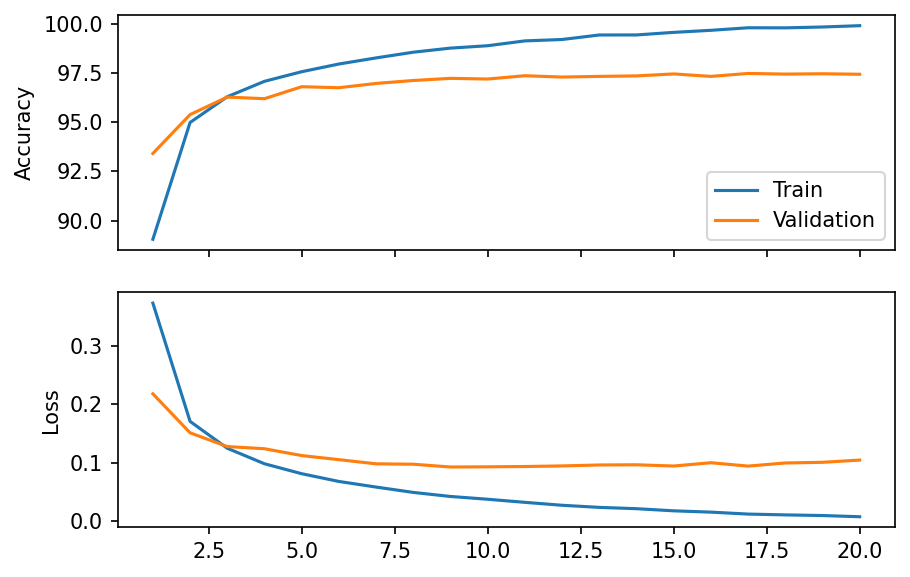

Précision en test: 97.60


In [15]:
net_without_dropout = MnistModel(2, use_dropout=False)
optimizer_without_dropout = optim.SGD(net_without_dropout.parameters(), lr, nesterov=True, momentum=0.9)

history_without_dropout = train(net_without_dropout, optimizer_without_dropout, mnist_train, n_epoch, batch_size, use_gpu=True)
history_without_dropout.display()
print('Précision en test: {:.2f}'.format(test(net_without_dropout, mnist_test, batch_size)))

Réseau avec dropout:

Epoch: 1/20 Step: 750/750 100.00% |█████████████████████████|6.17s loss: 0.579784 acc: 82.112500 val_loss: 0.228847 val_acc: 92.991667
Epoch: 2/20 Step: 750/750 100.00% |█████████████████████████|6.36s loss: 0.302873 acc: 91.020833 val_loss: 0.171631 val_acc: 94.791667
Epoch: 3/20 Step: 750/750 100.00% |█████████████████████████|5.97s loss: 0.244649 acc: 92.610417 val_loss: 0.152701 val_acc: 95.475000
Epoch: 4/20 Step: 750/750 100.00% |█████████████████████████|5.91s loss: 0.213067 acc: 93.702083 val_loss: 0.135048 val_acc: 95.833333
Epoch: 5/20 Step: 750/750 100.00% |█████████████████████████|6.33s loss: 0.189440 acc: 94.383333 val_loss: 0.120713 val_acc: 96.316667
Epoch: 6/20 Step: 750/750 100.00% |█████████████████████████|5.86s loss: 0.174152 acc: 94.854167 val_loss: 0.115719 val_acc: 96.500000
Epoch: 7/20 Step: 750/750 100.00% |█████████████████████████|6.22s loss: 0.163711 acc: 95.095833 val_loss: 0.112694 val_acc: 96.550000
Epoch: 8/20 Step: 750/750 100.00% |████████████████████

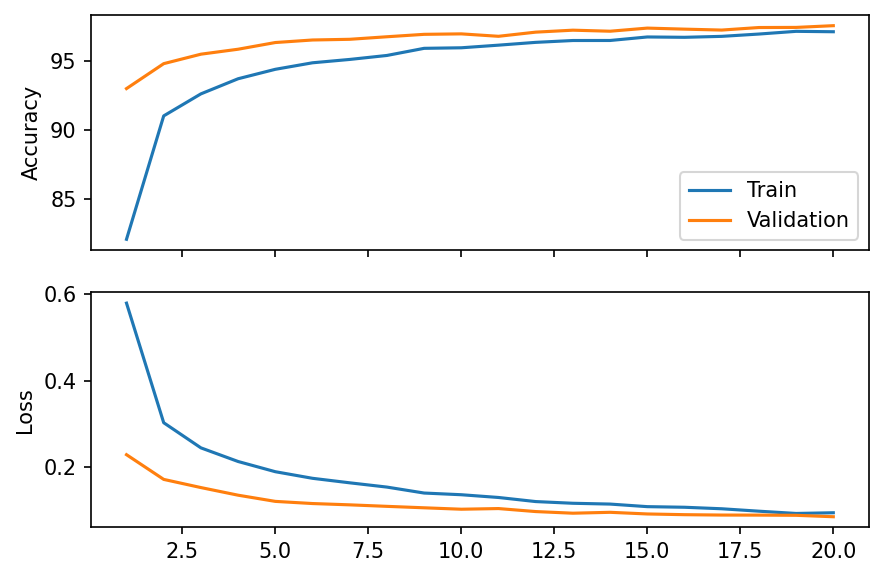

Précision en test: 97.67


In [16]:
net_with_dropout = MnistModel(2, use_dropout=True, dropout_p=0.3)
optimizer_with_dropout = optim.SGD(net_with_dropout.parameters(), lr, nesterov=True, momentum=0.9)

history_with_dropout = train(net_with_dropout, optimizer_with_dropout, mnist_train, n_epoch, batch_size, use_gpu=True)
history_with_dropout.display()
print('Précision en test: {:.2f}'.format(test(net_with_dropout, mnist_test, batch_size)))

#### Questions
- Quel est l'effet du dropout sur l'entraînement du réseau? **Sans dropout, le réseau a des performances en entraînement qui s'éloignent des performances en validation plus on avance dans les époques, c'est-à-dire du surapprentissage. À l'opposé, avec le dropout le réseau à des performances en entraînement proches des performances en validation tout au long des époques, avec même des résultats légèrement meilleurs en validation dans notre cas.**
- Essayez plusieurs valeurs de dropout et observez les effets.**Avec des valeurs de dropout trop faibles (0.01), il n'y a pas vraiment d'effets sur l'apprentissage du réseau. Avec des valeurs de dropout trop élevées (0.9), le réseau a de la difficulté à apprendre.**